In [1]:
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM, Dropout, Concatenate, Lambda
from keras.callbacks import ModelCheckpoint
from keras.saving import load_model

from keras import backend as K

from sklearn.preprocessing import MinMaxScaler

from pathlib import Path
from scripts.process_dataset import read_dataset_seq2seq
from notebooks.utils import draw_prediction, plot_loss


/home/pits/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-06-06 18:29:42.366532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749227382.474665   19633 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749227382.511407   19633 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def create_model(latent_dim, window_len, forecast_len, n_states, n_patches):
    encoder_inputs = Input(shape=(window_len, n_states*n_patches))
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    decoder_inputs = Input(shape=(forecast_len, n_patches))
    decoder_lstm = LSTM(latent_dim, return_sequences=True)
    x = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    x = Dense(512, activation='relu')(x)
    output = Dense(n_states*n_patches, activation="relu")(x)
    print(output.shape)

    model = Model([encoder_inputs, decoder_inputs], output)

    return model


In [2]:
window_len = 20
forecast_len = 130
nb_patches = 2
past, control, future, scaler = read_dataset_seq2seq("dataset/two_patches", window_len, forecast_len, nb_patches)
scaler_control = MinMaxScaler()
control = scaler_control.fit_transform(np.concatenate(control)).reshape(control.shape)

In [7]:
tf.keras.backend.clear_session()
model = create_model(512, window_len, forecast_len, 8, nb_patches)
model.compile(optimizer="adam", loss="mean_squared_error")


I0000 00:00:1749222114.383694   22152 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46407 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:55:00.0, compute capability: 8.6


(None, 130, 16)


In [8]:

model.fit([past, control], future, epochs=100, batch_size=20, validation_split=0.2)


Epoch 1/100


I0000 00:00:1749222136.258847   22225 cuda_dnn.cc:529] Loaded cuDNN version 90701


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2155 - val_loss: 0.0769
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0718 - val_loss: 0.0826
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0693 - val_loss: 0.0486
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0347 - val_loss: 0.0168
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - val_loss: 0.0113
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - val_loss: 0.0073
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0075
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - val_l

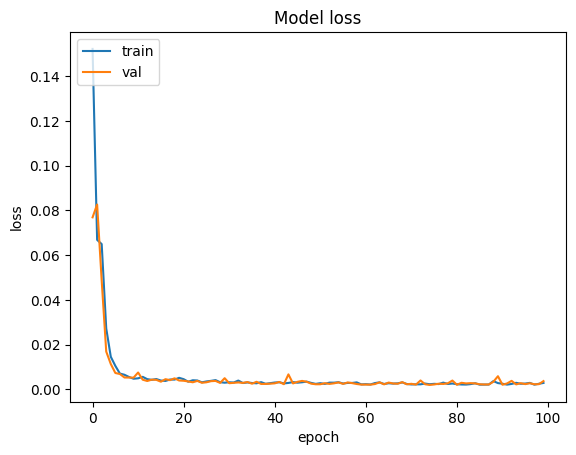

In [9]:
plot_loss(model)

In [3]:
model = load_model("seq2seq_model.keras")

2025-06-06 18:30:47.320514: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
tf.math.reduce_sum(model([past[0:1, :, :], control[0:1, :, :]])[0,-1])

<tf.Tensor: shape=(), dtype=float32, numpy=11.775455474853516>

In [4]:
def get_grad(a, b):
    with tf.GradientTape() as tape:
        mask = tf.cast(tf.range(control.shape[1])%7 == 0, tf.float32)[:, tf.newaxis]
        col_a = mask * a
        col_b = mask * b
        new_control = tf.concat([col_a, col_b], axis=1)
        #new_control = scaler_control.transform(new_control)
        z = tf.math.reduce_sum(model([tf.convert_to_tensor(past[0:1, :, :]), tf.reshape(new_control, [1, new_control.shape[0], -1]) ])[0,-1])
    return tape.gradient(z, {"a": a, "b": b})

In [5]:
a, b = tf.Variable(0.35684512), tf.Variable(0.28498443)
control_res = np.zeros_like(control[0, :, :])
control_res[::7, 0] = a.numpy()
control_res[::7, 1] = b.numpy()
print(a.numpy(), b.numpy())
print(np.sum(model([past[0:1, :, :], control_res.reshape((1, control_res.shape[0], -1))])[0,-1]))
learning_rate = 0.01
for _ in range(4):
    grad = get_grad(a, b)
    a.assign_add(-learning_rate*grad["a"])
    b.assign_add(-learning_rate*grad["b"])
control_res = np.zeros_like(control[0, :, :])
control_res[::7, 0] = a.numpy()
control_res[::7, 1] = b.numpy()
print(a.numpy(), b.numpy())
print(np.sum(scaler.inverse_transform(model([past[0:1, :, :], control_res.reshape((1, control_res.shape[0], -1))]))[0,-1]))
print(scaler_control.inverse_transform(control_res)[0])

0.3568451 0.28498444
11.775259
0.8600017 0.80368745


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
real, pred = moving_predict(X_trans, model_lookback, scaler, LOOKBACK, 80)
real = scaler.transform(real)
pred = scaler.transform(pred)
print(np.mean(np.square(real-pred)))

In [ ]:
draw_prediction(real, pred, 0)